<a href="https://colab.research.google.com/github/ugursirvermez/PyTorch_Education/blob/main/13_pytorch_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning

İçerik Sahibi: Adam Paszke <br>

[Linkten orijinal](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/9da0471a9eeb2351a488cd4b44fc6bbf/reinforcement_q_learning.ipynb) metine ulaşabilirsiniz. <br>

Agent, iki eylem arasında karar vermek zorundadır - arabayı sola veya sağa hareket ettirmek - böylece ona bağlı direk dik kalır. Gymnasium'un web sitesinde ortam ve diğer daha zorlu ortamlar hakkında daha fazla bilgi bulabilirsiniz. Ajan ortamın mevcut durumunu gözlemledikçe ve bir eylem seçtikçe, ortam yeni bir duruma geçer ve ayrıca eylemin sonuçlarını gösteren bir ödül döndürür. Bu görevde, ödüller her artımlı zaman adımı için +1'dir ve direk çok fazla devrilirse veya araba merkezden 2,4 birimden fazla uzaklaşırsa ortam sonlanır. Bu, daha iyi performans gösteren senaryoların daha uzun süre çalışacağı ve daha büyük getiri elde edeceği anlamına gelir.

CartPole görevi, agent'e girdilerin ortam durumunu (konum, hız vb.) temsil eden 4 gerçek değer olacak şekilde tasarlanmıştır. Bu 4 girdiyi herhangi bir ölçekleme yapmadan alırız ve her eylem için bir tane olmak üzere 2 çıktısı olan küçük, tamamen bağlı bir ağdan geçiririz. Ağ, girdi durumu verildiğinde her eylem için beklenen değeri tahmin edecek şekilde eğitilir. Daha sonra en yüksek beklenen değere sahip eylem seçilir.

https://gist.github.com/hatashiro/bb7584e890300b633339a3c09281d044

In [75]:
%%bash
pip3 install gymnasium[classic_control]

In [76]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay > /dev/null 2>&1
!pip install piglet
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


##Ortamın Kurulması

In [77]:
import gymnasium as gym #RL için kullanılan, çevre oluşturmayı sağlayan bir kütüphanedir.
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt #Grafik
from collections import namedtuple, deque #Verileri listelemek için
from itertools import count
from PIL import Image
import glob
import io
import os
import base64
#PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
#Görselleştirme için
import pyvirtualdisplay
from IPython import display as ipythondisplay
# matplotlib Kurulumu
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    from IPython.display import HTML

###### Environment #######
#Environment seçimi -> Oyunun adını yazıyoruz.
env = gym.make("CartPole-v1",render_mode="rgb_array")
plt.ion()

#Ekranı Başlatma
if not os.environ.get('DISPLAY'):
    pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# GPU mu yoksa CPU mu?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Video Kayıt

In [78]:
def render_as_image(env):
    img = env.render()
    img = Image.fromarray(img)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [79]:
def embed_video(video_path, width=640):
    content = io.open(video_path, 'rb').read()
    b64 = base64.b64encode(content)
    video_tag = '''

    '''.format(b64.decode(), width)
    ipythondisplay.display(ipythondisplay.HTML(video_tag))

In [80]:
import imageio
from datetime import datetime

def random_filename():
    return datetime.now().strftime('%Y_%m_%d_%H_%M_%S.mp4')

class VideoRecorder:
    def __init__(self, filename=random_filename(), fps=30):
        self.filename = filename
        self.writer = imageio.get_writer(filename, fps=fps)

    def record_frame(self, env):
        frame = env.render()
        self.writer.append_data(frame)

    def close(self, *args, **kwargs):
        self.writer.close(*args, **kwargs)

    def play(self):
        self.close()
        embed_video(self.filename)

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self.play()

## Tekrarlı Hafıza Oluşturma

In [81]:
#Bu değişken birden fazla etikete sahip.
#Etiketler -> Durum, eylem, sonraki durum ve ödülden oluşuyor.
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#Agent'ın yaptığı eylemler sonucunda hafızasını oluşturuyoruz.
class ReplayMemory(object):

    #Hafızanın kapasitesini belirliyoruz.
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    #Her bir veriyi transition adlı değişkene aktarıyoruz.
    def push(self, *args):
        self.memory.append(Transition(*args))
    #Verileri karşılaştırmak için hafızamızdan batch miktarı
    #kadar veriyi rastgele seçiyoruz.
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    #Hafıza miktarı ne kadar oldu bunu döndüren fonksiyon
    def __len__(self):
        return len(self.memory)

## DQN Algoritması
Çevremiz deterministiktir, bu nedenle burada sunulan tüm denklemler basitlik adına deterministik olarak formüle edilmiştir. Takviyeli öğrenme literatüründe, çevredeki stokastik geçişler üzerindeki beklentileri de içerirler. Amacımız, iskontolu, kümülatif ödülü maksimize etmeye çalışan bir politika eğitmek olacaktır, **𝑅𝑡0=∑∞𝑡=𝑡0𝛾𝑡−𝑡0𝑟𝑡 **, burada 𝑅𝑡0 aynı zamanda getiri olarak da bilinir. İskonto, 𝛾 , toplamın yakınsamasını sağlayan 0 ile 1 arasında bir sabit olmalıdır. Daha düşük bir 𝛾 , belirsiz uzak gelecekten gelen ödülleri, hakkında oldukça emin olabileceği yakın gelecekteki ödüllerden daha az önemli hale getirir. Ayrıca, temsilcileri, gelecekte zamansal olarak uzak olan eşdeğer ödüllerden daha yakın zamanda ödül toplamaya teşvik eder. <br>

Q-öğrenmesinin arkasındaki temel fikir, eğer **𝑄:𝑆𝑡𝑎𝑡𝑒×𝐴𝑐𝑡𝑖𝑜𝑛→ℝ** şeklinde bir fonksiyonumuz olsaydı ve bu fonksiyon bize belirli bir durumda bir eylemde bulunursak getirimizin ne olacağını söyleyebilseydi, ödüllerimizi en üst düzeye çıkaracak bir politikayı kolayca oluşturabilirdik:
### 𝜋∗(𝑠)=argmax𝑎 𝑄∗(𝑠,𝑎) <br>

### Q-network
Modelimiz, geçerli ve önceki ekran yamaları arasındaki farkı alan ileri beslemeli bir sinir ağı olacak. 𝑄(𝑠,sol) ve 𝑄(𝑠,sağ)'ı temsil eden iki çıktısı var (burada 𝑠, ağın girdisidir). Aslında, ağ, geçerli girdi verildiğinde her eylemin beklenen getirisini tahmin etmeye çalışmaktadır.

In [82]:
#DQN Sınıfı Oluşturarak Veri Analizi Yapılacak
class DQN(nn.Module):
    #Gözlemler ve eylemler sonucunda doğrusal bir veri azalması olmalı.
    #Bu veri azalması eylem ve durumun bir orantısı ile sağlanabilir.
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Bir sonraki eylemi belirlemek için bir öğeyle veya
    # optimizasyon sırasında bir toplu işlemle çağrılır.
    # Tensor([[left0exp,right0exp]...]) döndürür.
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Eğitim

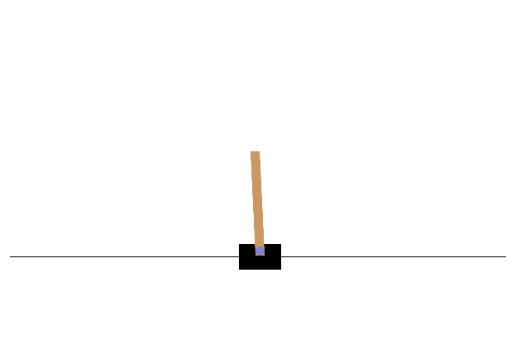

In [83]:
BATCH_SIZE = 128 # tekrar oynatma arabelleğinden örneklenen geçişlerin sayısıdır
GAMMA = 0.99 # önceki bölümde belirtildiği gibi indirim faktörüdür
EPS_START = 0.9 # EPS_START epsilon'un başlangıç ​​değeridir
EPS_END = 0.05 # EPS_END epsilon'un son değeridir.
EPS_DECAY = 1000 # epsilonun üstel azalma oranını kontrol eder; daha yüksek değer daha yavaş azalma anlamına gelir
TAU = 0.005 # hedef ağın güncelleme oranıdır
LR = 1e-4 # Öğrenme oranı Adam optimizer'a göre

#Ortamın Görselini çıkarma
env.reset()
render_as_image(env)

# Ortam eylem sayısını alma
n_actions = env.action_space.n
# Durum gözlemlerini alma
state, info = env.reset()
n_observations = len(state)

#Hedef ve uygulanacak protokol değerlerini alma
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
#Optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000) #Ne kadarlık hafıza oluşacak?

#Kaç adım yapıldı
steps_done = 0

#Eylem Seçimi
def select_action(state):
    global steps_done
    sample = random.random()
    #Yukarıdaki formül uygulanıyor.
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            #En yüksek değere ulaşmak için eylemlerdeki ödülleri takip ediyoruz.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

#Devirlerin süresi
episode_durations = []

#Devir sürelerini grafikleştirme
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # 100 tane olmalı en az
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # grafik güncelleme süresi
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

## Eğitim Döngüsünü Oluşturma

In [84]:
#Modeli İyileştirme
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions)) #Durumlar, eylemler, sonraki durumlar ve ödüller

    # Bütün durumları bir araya getirme. Tuple ile.
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    #Durumları gözlemleyip eylemlerin gidişatını belirliyoruz.
    # Eylem durumu ne getirdi? Bu eylemin sonucunda ödül mü var?
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Alınan bütün ödül değerleri değerlendirilir ve değerlendirilen ödüllerden
    # son duruma ulaşılır.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss ölçümü
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    #Optimizer
    optimizer.zero_grad()
    loss.backward()
    # Gradyen azaltma
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

## Döngüyü Çalıştırma

Bitti!


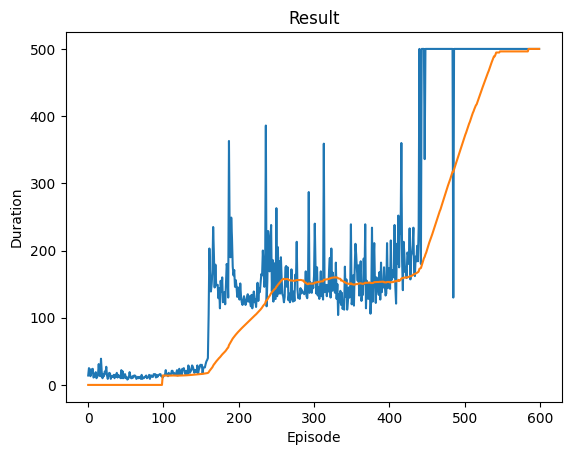

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [85]:
# İşlemci seçimine göre döngü sayısı oluşturuluyor.
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

with VideoRecorder() as video_recorder:
  for i_episode in range(num_episodes):
      # Env oluşturulup durumlar hazırlanıyor.
      state, info = env.reset()

      #State'in boyutu bir arttırılıyor.
      state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

      for t in count():
          #Video kaydı alma
          video_recorder.record_frame(env)
          #Eylem, gözlem, ödül vs. yazdırılıyor.
          action = select_action(state)
          observation, reward, terminated, truncated, _ = env.step(action.item())
          reward = torch.tensor([reward], device=device)
          done = terminated or truncated

          if terminated:
              next_state = None
          else:
              next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

          # Elde edilen deneyi hafızaya atacağız.
          memory.push(state, action, next_state, reward)

          # Sonraki duruma geç
          state = next_state

          # Optimizer ve Loss
          optimize_model()

          # Hafif değer güncellemesi yapılacak.
          target_net_state_dict = target_net.state_dict()
          policy_net_state_dict = policy_net.state_dict()
          for key in policy_net_state_dict:
              target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
          target_net.load_state_dict(target_net_state_dict)

          if done:
              episode_durations.append(t + 1)
              plot_durations()
              break

print('Bitti!')
plot_durations(show_result=True)
plt.ioff()
plt.show()